In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("C://Users/sz/Desktop/practice/take_home_challenges/")
import helper_f
%matplotlib inline

# Questions

- Figure out percentage of users who opened email and what percentage clicked on link
- Optimize future email campaign by locating better group of users who are likely to click on link
- click through rate improvement by the model? how to test it
- interesting patterns

read three tables

### Question 1,  10.345% users opened link, and 2.119% users clicked the link

In [2]:
email = pd.read_csv("email_table.csv")
opened = pd.read_csv("email_opened_table.csv")
clicked = pd.read_csv("link_clicked_table.csv")

In [3]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [4]:
#check missing values
email.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
opened.head(3)

,email_id
0,284534
1,609056
2,220820


In [6]:
#opened table info 
opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [7]:
clicked.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [8]:
clicked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


In [9]:
#number of unique emmail ids in three tables
print("Email table: {}".format(len(email['email_id'].unique())))
print("Opened table: {}".format(len(opened['email_id'].unique())))
print("Clicked table: {}".format(len(clicked['email_id'].unique())))

Email table: 100000
Opened table: 10345
Clicked table: 2119


In [10]:
#create two columns 'opened' and 'clicked' in email table
email['opened'] = email['email_id'].apply(lambda idx: 1 if idx in opened.email_id.values else 0)
email['clicked'] = email['email_id'].apply(lambda idx: 1 if idx in clicked.email_id.values else 0)

In [11]:
#highly imbalanced dataset
print("Pertange of people who opened: {}%".format(np.mean(email['opened']*100)))
print("Pertange of people who clicked {}%".format(np.mean(email['clicked']*100)))

Pertange of people who opened: 10.345%
Pertange of people who clicked 2.119%


In [12]:
#make sure there is no 'clicked but not opened error'
#very strangely, there are 50 users who clicked but not opened. This could be an error
print("Number of people who clicked but not opened: {}".format(np.sum(email['clicked'] > email['opened'])))

Number of people who clicked but not opened: 50


### Question 4
Based on below visualizations, clearly every factor affects user's decision to click since there are measurable difference on each factor for clicked and non-clicked users

In [13]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


clicked
0    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
1    [[AxesSubplot(0.125,0.125;0.336957x0.755), Axe...
dtype: object

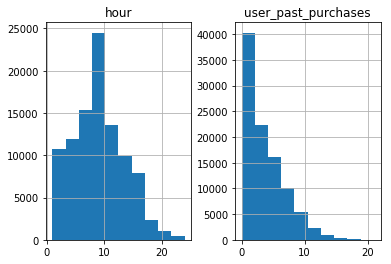

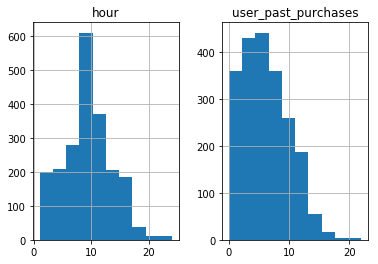

In [14]:
#look at a quick distribution of hour and past purchase for two groups
email.groupby(['clicked']).hist(column = ['hour','user_past_purchases'])

- Analyze the effect of **email_text**

Short emails have higher click through rate than longer emails

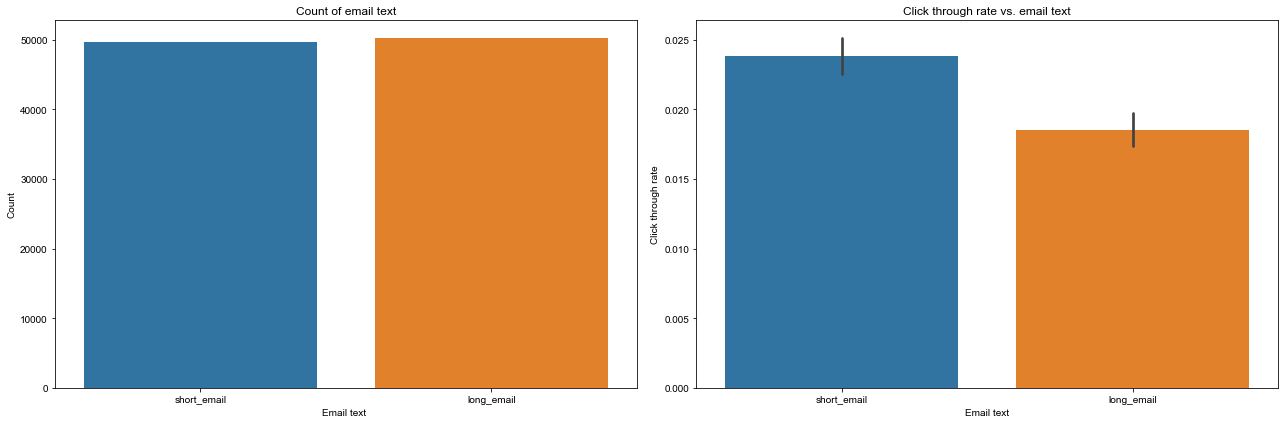

In [15]:
fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (18,6))
sns.set_style("whitegrid")

sns.countplot(x = 'email_text', data = email, ax = ax[0])
ax[0].set_xlabel('Email text ')
ax[0].set_ylabel('Count')
ax[0].set_title("Count of email text")

sns.barplot(x = 'email_text', y = 'clicked', data = email, ax = ax[1])
ax[1].set_xlabel('Email text')
ax[1].set_ylabel('Click through rate')
ax[1].set_title('Click through rate vs. email text')
plt.tight_layout()

- Analyze the effect of **email_version**

Personalized emails have higher click through rate than generic emails

Text(0,0.5,'Click through rate')

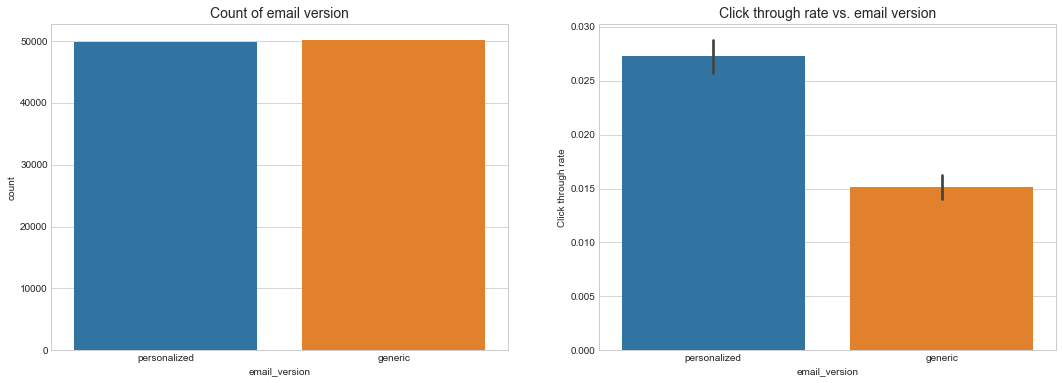

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (18,6))

sns.set_style('darkgrid')

sns.countplot(x = 'email_version', data = email, ax = ax[0])
ax[0].set_title('Count of email version', fontsize = 14)

sns.barplot(x = 'email_version',y = 'clicked', data = email, ax = ax[1])
ax[1].set_title("Click through rate vs. email version", fontsize = 14)
ax[1].set_ylabel('Click through rate')

- Analyze the effect of **weekday**

Click through rate for Wednesday is highest, while Friday and Sunday much lower

Text(0,0.5,'Click through rate')

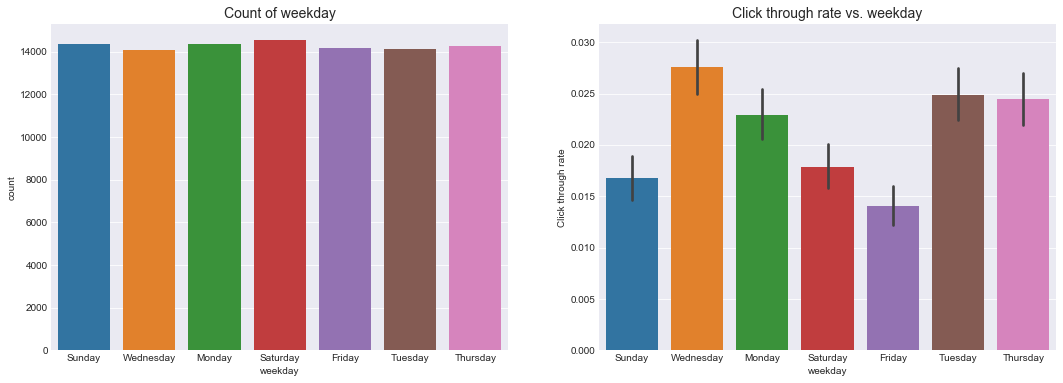

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (18,6))

sns.set_style('whitegrid')

sns.countplot(x = 'weekday', data = email, ax = ax[0])
ax[0].set_title('Count of weekday', fontsize = 14)

sns.barplot(x = 'weekday',y = 'clicked', data = email, ax = ax[1])
ax[1].set_title("Click through rate vs. weekday", fontsize = 14)
ax[1].set_ylabel('Click through rate')

- Analyze the effect of **country**

UK,US have more than 2.5x higher click through rate than FR and ES

Text(0,0.5,'Click through rate')

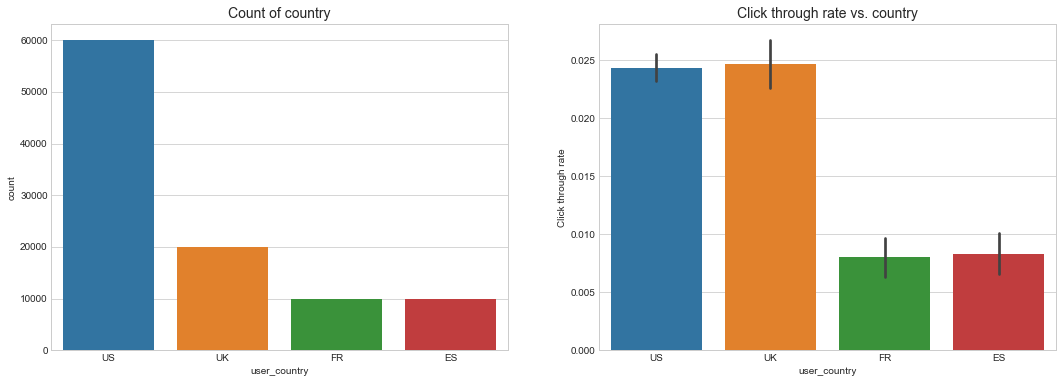

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (18,6))

sns.set_style('whitegrid')

sns.countplot(x = 'user_country', data = email, ax = ax[0])
ax[0].set_title('Count of country', fontsize = 14)

sns.barplot(x = 'user_country',y = 'clicked', data = email, ax = ax[1])
ax[1].set_title("Click through rate vs. country", fontsize = 14)
ax[1].set_ylabel('Click through rate')

- Analyze the effect of **past purchases**

mean purchase for clicked users is 1.5x higher than not clicked users

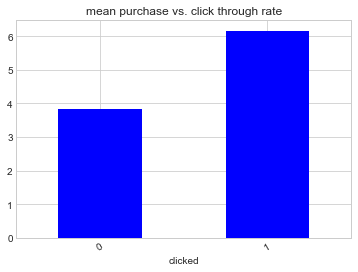

In [19]:
past_purchase = email.groupby('clicked')['user_past_purchases'].mean()
past_purchase.plot(kind = 'bar', title = 'mean purchase vs. click through rate', rot = 30, color = 'b')

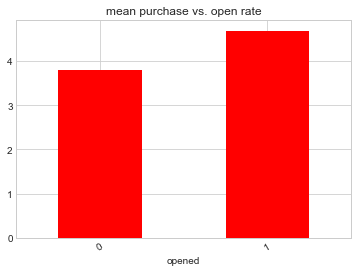

In [20]:
past_purchase_open = email.groupby('opened')['user_past_purchases'].mean()
past_purchase_open.plot(kind = 'bar', title = 'mean purchase vs. open rate', rot = 30, color ='r')

- Analyze the effect of **hour**<br\>

clicked
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hour, dtype: object

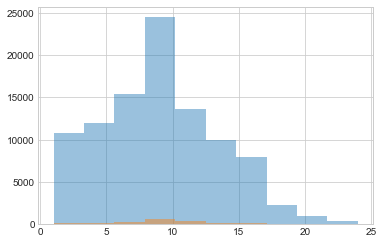

In [21]:
#we see two groups overlap on hour
email.groupby('clicked')['hour'].hist(alpha = 0.45)

Text(0,0.5,'Click through rate')

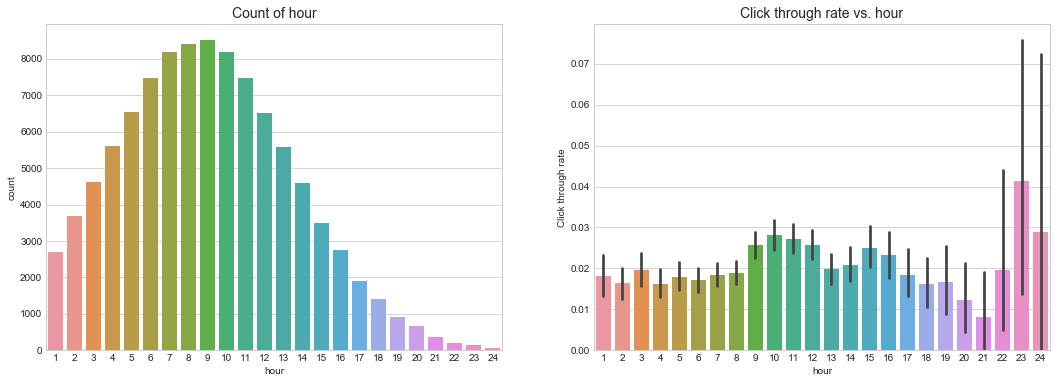

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (18,6))

sns.set_style('darkgrid')

sns.countplot(x = 'hour', data = email, ax = ax[0])
ax[0].set_title('Count of hour', fontsize = 14)

sns.barplot(x = 'hour',y = 'clicked', data = email, ax = ax[1])
ax[1].set_title("Click through rate vs. hour", fontsize = 14)
ax[1].set_ylabel('Click through rate')

### Question 2. Build a model

Based on below model, the company can send emails to users that have higher probability of click

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

model_data = email.drop(['email_id','opened'],axis=1)

le = LabelEncoder()
for col in ['email_text', 'email_version', 'user_country', 'weekday']:
    model_data[col] = le.fit_transform(model_data[col])

X,y = model_data.loc[:,model_data.columns!='clicked'], model_data['clicked']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.25, random_state = 44)

In [24]:
from sklearn.metrics import classification_report


clf = RandomForestClassifier()
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)
pred = (probs[:,1] > 0.5).astype('int')

print(classification_report(y_true=y_test, y_pred= pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99     24470
          1       0.06      0.01      0.02       530

avg / total       0.96      0.98      0.97     25000



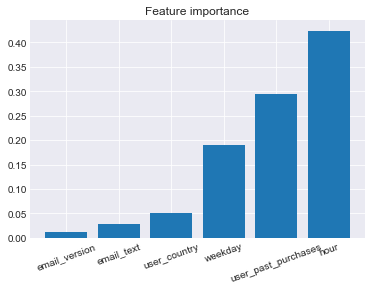

In [25]:
#feature importance
helper_f.plot_feature_importance(X_train, 'clicked', clf, degree=20)

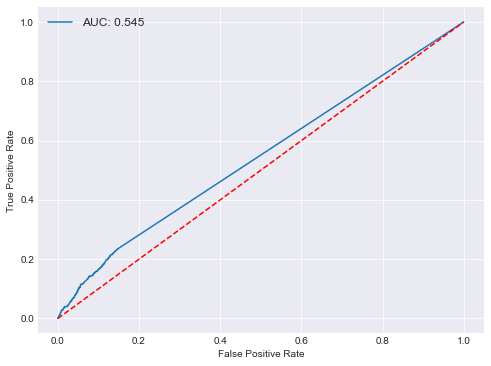

In [26]:
#ROC curve 
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, probs[:,1])
auc = np.round(auc(fpr, tpr),3)

fig, ax = plt.subplots(figsize = (8,6))
ax.plot(fpr, tpr, label = 'AUC: '+str(auc))
ax.plot([0, 1], [0, 1],'r--')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize = 12)

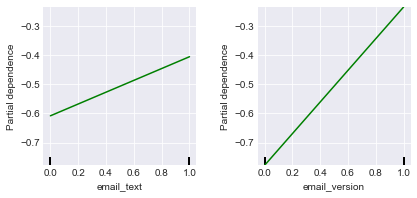

In [27]:
#partial dependence plot
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble import GradientBoostingClassifier

GBM = GradientBoostingClassifier()
GBM.fit(X_train, y_train)

#first two features
pdp_plot = plot_partial_dependence(GBM, features = [0,1], X = X_train, feature_names=['email_text', 'email_version'])

Text(0.5,1,'Partial dependence plot of 4 features')

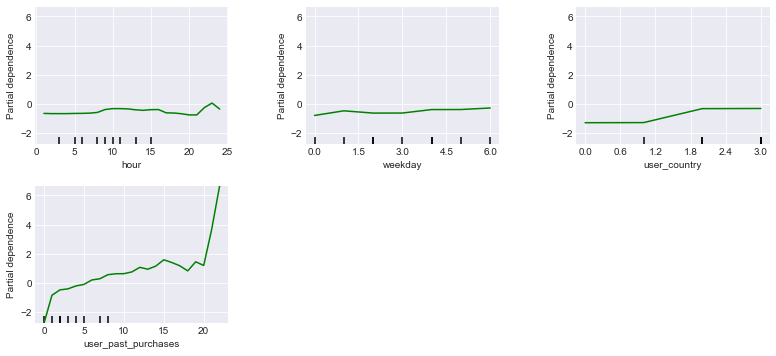

In [28]:
#partial dependence plot of hour, weekday, country, past_purchase
fig, ax1 = plt.subplots(figsize = (12,8))
plot_partial_dependence(GBM, features = [2,3,4,5], X=X_train, feature_names= X_train.columns, ax = ax1)
ax1.set_title("Partial dependence plot of 4 features")

### Question 3. Test my model with A/B test

- Randomly assign users to control and experiment group
- Use old email strategy to send emails to users in control group
- Use above model to predict user click, and only send emails to those whose prediction is click
- Use t-test to test whether Experiment group's click through rate is higher than that of control group